In [1]:
from imports import *

### Cargando datos temporales

In [2]:
# Leer el archivo Parquet
table_loaded = pq.read_table("6'_20ophits.parquet")

# Convertir de vuelta a Awkward Array o NumPy
input = ak.to_numpy(table_loaded["input"])
nuvT_c = ak.to_numpy(table_loaded["nuvT_c"])

print("Loaded matrix shape:", input.shape)  # Debería ser (21900, 400, 4)
print("Loaded vector shape:",nuvT_c.shape)  # Debería ser (21900,))
print("Matrix sample:\n", input[0, :3])
print("Vector sample:", nuvT_c[:3])

Loaded matrix shape: (21964, 80, 4)
Loaded vector shape: (21964,)
Matrix sample:
 [[1478.72460015   70.            0.            0.        ]
 [1480.72460015   16.            0.            0.        ]
 [1480.72460015   14.            0.            0.        ]]
Vector sample: [1462.42688725 1480.24647869  643.02543649]


### Cargando datos espaciales

In [3]:
image = np.load("/data/vidales/images/image_v1303_onlype.npy")

In [9]:
print(image.shape)

(21964, 59, 70, 8)


### Cargando etiquetas

In [4]:
table = pq.read_table('saved_archives/v1303_noTPCselection_c1&c2.parquet')
dEpromx = ak.from_iter(table.column('dEpromx').to_pylist())
dEpromy = ak.from_iter(table.column('dEpromy').to_pylist())
dEpromz = ak.from_iter(table.column('dEpromz').to_pylist())
del table

dEpromx = np.array(dEpromx).flatten()
dEpromy = np.array(dEpromy).flatten()
dEpromz = np.array(dEpromz).flatten()

dEpromx = dEpromx.reshape(-1, 1)
dEpromy = dEpromy.reshape(-1, 1)
dEpromz = dEpromz.reshape(-1, 1)

In [5]:
#y = np.column_stack((nuvT_c, dEpromx_f, dEpromy_f, dEpromz_f))
y = np.column_stack((nuvT_c, dEpromx, dEpromy, dEpromz))
y_np = ak.to_numpy(y)
print("Merged y_np:")
print(y_np)
print(np.shape(y_np))

Merged y_np:
[[1462.42688725 -141.81035117  140.83112553   74.82157564]
 [1480.24647869 -128.18496115  158.65734985  187.35995061]
 [ 643.02543649   89.7728596  -156.06595153  218.71311199]
 ...
 [ 891.94434413 -124.34233789   15.40607009  319.10272126]
 [ 514.17493045  122.74146747   88.72589418  287.34965045]
 [ 268.03104886   36.9916876    78.19434956  251.45103767]]
(21964, 4)


In [6]:
from sklearn.preprocessing import MinMaxScaler
# Define the column indices you want to scale to [0, 1] and [-1, 1]
# For 4 entries (t,x,y,z):

columns_0_to_1 = [0,3]  # For example, columns 0 and 2 to scale to [0, 1]
columns_minus1_to_1 = [1,2]  # For example, columns 1 and 3 to scale to [-1, 1]

# For 3 entries (x,y,z):

#columns_0_to_1 = [2]  # For example, columns 0 and 2 to scale to [0, 1]
#columns_minus1_to_1 = [0, 1]  # For example, columns 1 and 3 to scale to [-1, 1]

# Initialize two scalers
scaler_0_1 = MinMaxScaler(feature_range=(0, 1))
scaler_minus1_1 = MinMaxScaler(feature_range=(-1, 1))

# Apply scaling for columns that need [0, 1]
y_np_scaled_0_1 = np.copy(y_np)  # Make a copy to avoid modifying the original data
y_np_scaled_0_1[:, columns_0_to_1] = scaler_0_1.fit_transform(y_np[:, columns_0_to_1])

# Apply scaling for columns that need [-1, 1]
y_np_scaled_minus1_1 = np.copy(y_np)  # Make a copy to avoid modifying the original data
y_np_scaled_minus1_1[:, columns_minus1_to_1] = scaler_minus1_1.fit_transform(y_np[:, columns_minus1_to_1])

# Combine the results (scaled data)
y_scaled_combined = np.copy(y_np)  # Start with the original data
y_scaled_combined[:, columns_0_to_1] = y_np_scaled_0_1[:, columns_0_to_1]
y_scaled_combined[:, columns_minus1_to_1] = y_np_scaled_minus1_1[:, columns_minus1_to_1]

# Print the scaled data
print("Scaled Data (columns 0 and 3 -> scaled to [0, 1] and columns 1 and 2 -> scaled to [-1, 1]):")
print(y_scaled_combined)

Scaled Data (columns 0 and 3 -> scaled to [0, 1] and columns 1 and 2 -> scaled to [-1, 1]):
[[ 0.95919574 -0.70778976  0.69523988  0.13987098]
 [ 0.97086068 -0.63959104  0.7834291   0.36412399]
 [ 0.42280517  0.45134609 -0.77355807  0.42660082]
 ...
 [ 0.58575064 -0.62035768  0.0747418   0.62664522]
 [ 0.33845799  0.61636279  0.43746685  0.5633715 ]
 [ 0.17732909  0.18716222  0.3853656   0.49183704]]


In [7]:
test_size = int(np.floor(0.20*np.shape(y_np)[0]) )
print(test_size)

X_train_temp, X_test_temp = input[:-test_size], input[-test_size:]
print('x_train_temp dim.:',X_train_temp.shape)
print('x_test_temp dim.:', X_test_temp.shape)

X_train_esp, X_test_esp = image[:-test_size], image[-test_size:]
print('x_train_esp dim.:',X_train_esp.shape)
print('x_test_esp dim.:', X_test_esp.shape)

y_train, y_test = y_scaled_combined[:-test_size], y_scaled_combined[-test_size:]

4392
x_train_temp dim.: (17572, 80, 4)
x_test_temp dim.: (4392, 80, 4)
x_train_esp dim.: (17572, 59, 70, 8)
x_test_esp dim.: (4392, 59, 70, 8)


### Modelo

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Layer, LeakyReLU, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.regularizers import l2

# MaskNegative1000 Layer (from your original code)
class MaskNegative1000(Layer):
    def __init__(self, **kwargs):
        super(MaskNegative1000, self).__init__(**kwargs)
    
    def call(self, inputs):
        mask = tf.reduce_any(inputs != tf.constant(-1000.0, dtype=tf.float32), axis=-1)
        return inputs, mask

def combined_model(x_train_lstm, x_train_cnn):
    """
    Creates and returns a combined model with an LSTM network for temporal prediction
    and a CNN network for spatial prediction.

    Parameters:
    - x_train_lstm: Input data for the LSTM model (temporal data).
    - x_train_cnn: Input data for the CNN model (spatial data).
    
    Returns:
    - model: A compiled model.
    """
    # Define the LSTM model (Temporal prediction)
    inputs_lstm = Input(shape=(x_train_lstm.shape[1], x_train_lstm.shape[2]))
    masked_inputs, mask = MaskNegative1000()(inputs_lstm)

    lstm_out1 = LSTM(512, return_sequences=True)(masked_inputs, mask=mask)
    lstm_out2 = LSTM(256, return_sequences=True)(lstm_out1, mask=mask)
    lstm_out3 = LSTM(128, return_sequences=False)(lstm_out2, mask=mask)

    x_lstm = Dense(64, kernel_regularizer=l2(0.01))(lstm_out3)
    output_lstm = Dense(1)(x_lstm)  # Temporal output

    # Define the CNN model (Spatial prediction)
    inputs_cnn = Input(shape=(x_train_cnn.shape[1], x_train_cnn.shape[2], x_train_cnn.shape[3]))  # Adapt the input shape if needed
    model_cnn = Conv2D(32, (3, 3), padding='same')(inputs_cnn)
    model_cnn = BatchNormalization()(model_cnn)
    model_cnn = LeakyReLU(alpha=0.1)(model_cnn)
    model_cnn = MaxPooling2D((2, 2), padding='same')(model_cnn)

    model_cnn = Conv2D(64, (3, 3), padding='same')(model_cnn)
    model_cnn = BatchNormalization()(model_cnn)
    model_cnn = LeakyReLU(alpha=0.1)(model_cnn)
    model_cnn = MaxPooling2D((2, 2), padding='same')(model_cnn)

    model_cnn = Conv2D(128, (3, 3), padding='same')(model_cnn)
    model_cnn = BatchNormalization()(model_cnn)
    model_cnn = LeakyReLU(alpha=0.1)(model_cnn)
    model_cnn = MaxPooling2D((2, 2), padding='same')(model_cnn)

    model_cnn = Conv2D(256, (3, 3), padding='same')(model_cnn)
    model_cnn = BatchNormalization()(model_cnn)
    model_cnn = LeakyReLU(alpha=0.1)(model_cnn)
    model_cnn = MaxPooling2D((2, 2), padding='same')(model_cnn)

    model_cnn = Flatten()(model_cnn)
    model_cnn = Dense(1024, activation='relu')(model_cnn)
    model_cnn = Dropout(0.3)(model_cnn)
    model_cnn = Dense(512, activation='relu')(model_cnn)
    model_cnn = Dropout(0.3)(model_cnn)
    model_cnn = Dense(256, activation='relu')(model_cnn)
    model_cnn = Dropout(0.3)(model_cnn)
    model_cnn = Dense(128, activation='relu')(model_cnn)
    model_cnn = Dropout(0.3)(model_cnn)

    output_cnn = Dense(3, activation='linear')(model_cnn)  # Spatial output (3 coordinates)

    # Concatenate the outputs from LSTM and CNN models
    concatenated = layers.concatenate([output_lstm, output_cnn])

    # Define the fully connected layers
    fc = Dense(64, kernel_regularizer=l2(0.01))(concatenated)
 
    # Final output layer (total of 4 variables: 1 temporal + 3 spatial)
    final_output = Dense(4, activation='linear')(fc)

    # Create the combined model
    combined_model = Model(inputs=[inputs_lstm, inputs_cnn], outputs=final_output)

    # Compile the model
    combined_model.compile(loss='mse', optimizer='adam', metrics=['mse'])

    # Return the model
    return combined_model


In [33]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Layer, LeakyReLU, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.regularizers import l2

# MaskNegative1000 Layer
class MaskNegative1000(Layer):
    def __init__(self, **kwargs):
        super(MaskNegative1000, self).__init__(**kwargs)
    
    def call(self, inputs):
        mask = tf.reduce_any(inputs != tf.constant(-1000.0, dtype=tf.float32), axis=-1)
        return inputs, mask

def combined_model_boosted(x_train_lstm, x_train_cnn):
    """
    Creates and returns a combined model with an LSTM network for temporal prediction
    and a CNN network for spatial prediction.
    """
    # Define the LSTM model
    inputs_lstm = Input(shape=(x_train_lstm.shape[1], x_train_lstm.shape[2]))
    masked_inputs, mask = MaskNegative1000()(inputs_lstm)
    
    lstm_out1 = LSTM(256, return_sequences=True)(masked_inputs, mask=mask)
    lstm_out2 = LSTM(128, return_sequences=False)(lstm_out1)
    
    x_lstm = Dense(64, kernel_regularizer=l2(0.01))(lstm_out2)
    x_lstm = LeakyReLU(alpha=0.1)(x_lstm)
    x_lstm = Dropout(0.3)(x_lstm)
    output_lstm = Dense(1)(x_lstm)  # Temporal output

    # Define the CNN model
    inputs_cnn = Input(shape=(x_train_cnn.shape[1], x_train_cnn.shape[2], x_train_cnn.shape[3]))
    model_cnn = Conv2D(32, (3, 3), padding='same')(inputs_cnn)
    model_cnn = BatchNormalization()(model_cnn)
    model_cnn = LeakyReLU(alpha=0.1)(model_cnn)
    model_cnn = MaxPooling2D((2, 2), padding='same')(model_cnn)

    model_cnn = Conv2D(64, (3, 3), padding='same')(model_cnn)
    model_cnn = BatchNormalization()(model_cnn)
    model_cnn = LeakyReLU(alpha=0.1)(model_cnn)
    model_cnn = MaxPooling2D((2, 2), padding='same')(model_cnn)

    model_cnn = Conv2D(128, (3, 3), padding='same')(model_cnn)
    model_cnn = BatchNormalization()(model_cnn)
    model_cnn = LeakyReLU(alpha=0.1)(model_cnn)
    model_cnn = MaxPooling2D((2, 2), padding='same')(model_cnn)

    model_cnn = Conv2D(256, (3, 3), padding='same')(model_cnn)
    model_cnn = BatchNormalization()(model_cnn)
    model_cnn = LeakyReLU(alpha=0.1)(model_cnn)
    model_cnn = MaxPooling2D((2, 2), padding='same')(model_cnn)

    model_cnn = Flatten()(model_cnn)
    model_cnn = Dense(1024, activation='relu')(model_cnn)
    model_cnn = Dropout(0.3)(model_cnn)
    model_cnn = Dense(512, activation='relu')(model_cnn)
    model_cnn = Dropout(0.3)(model_cnn)
    model_cnn = Dense(256, activation='relu')(model_cnn)
    model_cnn = Dropout(0.3)(model_cnn)
    model_cnn = Dense(128, activation='relu')(model_cnn)
    model_cnn = Dropout(0.3)(model_cnn)

    output_cnn = Dense(3, activation='linear')(model_cnn)  # Spatial output

    # Concatenate the outputs
    concatenated = layers.concatenate([output_lstm, output_cnn])

    # Fully connected layers
    fc = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(concatenated)
    fc = Dropout(0.3)(fc)
    fc = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(fc)
    fc = Dropout(0.3)(fc)
    fc = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(fc)
    fc = Dropout(0.3)(fc)
    
    # Final output layer
    final_output = Dense(4, activation='linear')(fc)

    # Create the model
    combined_model = Model(inputs=[inputs_lstm, inputs_cnn], outputs=final_output)
    combined_model.compile(loss='mse', optimizer='adam', metrics=['mse'])

    return combined_model


In [48]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Layer, LeakyReLU, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.regularizers import l2

# MaskNegative1000 Layer (unchanged)
class MaskNegative1000(Layer):
    def __init__(self, **kwargs):
        super(MaskNegative1000, self).__init__(**kwargs)
    
    def call(self, inputs):
        mask = tf.reduce_any(inputs != tf.constant(-1000.0, dtype=tf.float32), axis=-1)
        return inputs, mask

def combined_model_resnet(x_train_lstm, x_train_cnn):
    """
    Creates and returns a combined model with an LSTM network for temporal prediction
    and a ResNet-18 network for spatial prediction.

    Parameters:
    - x_train_lstm: Input data for the LSTM model (temporal data).
    - x_train_cnn: Input data for the CNN model (spatial data).
    
    Returns:
    - model: A compiled model.
    """
    # Define the LSTM model (Temporal prediction) - unchanged
    inputs_lstm = Input(shape=(x_train_lstm.shape[1], x_train_lstm.shape[2]))
    masked_inputs, mask = MaskNegative1000()(inputs_lstm)

    lstm_out1 = LSTM(512, return_sequences=True)(masked_inputs, mask=mask)
    lstm_out2 = LSTM(256, return_sequences=True)(lstm_out1, mask=mask)
    lstm_out3 = LSTM(128, return_sequences=False)(lstm_out2, mask=mask)

    x_lstm = Dense(64, kernel_regularizer=l2(0.01))(lstm_out3)
    
    output_lstm = Dense(1)(x_lstm)  # Temporal output

    # Define the ResNet-18 model (Spatial prediction)
    inputs_cnn = Input(shape=(x_train_cnn.shape[1], x_train_cnn.shape[2], x_train_cnn.shape[3]))  # e.g., (57, 60, 16)

    # Initial convolution layer
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(inputs_cnn)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Define the basic residual block
    def basic_block(input, filters, stride=1, downsample=False):
        shortcut = input

        # First convolution in the block
        x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False)(input)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

        # Second convolution in the block
        x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)

        # Downsample the shortcut if needed
        if downsample:
            shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', use_bias=False)(input)
            shortcut = layers.BatchNormalization()(shortcut)

        # Add shortcut to the main path
        x = layers.Add()([x, shortcut])
        x = layers.ReLU()(x)
        return x

    # ResNet-18 stages
    # Stage 1: 2 blocks with 64 filters
    x = basic_block(x, 64)
    x = basic_block(x, 64)

    # Stage 2: 2 blocks with 128 filters
    x = basic_block(x, 128, stride=2, downsample=True)
    x = basic_block(x, 128)

    # Stage 3: 2 blocks with 256 filters
    x = basic_block(x, 256, stride=1, downsample=True)  # Adjusted stride for smaller input
    x = basic_block(x, 256)

    # Stage 4: 2 blocks with 512 filters
    x = basic_block(x, 512, stride=1, downsample=True)  # Adjusted stride for smaller input
    x = basic_block(x, 512)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Dropout and Dense layer for spatial output
    x = layers.Dropout(0.4)(x)
    output_cnn = layers.Dense(3, activation='linear')(x)  # Spatial output (3 coordinates)

    # Concatenate the outputs from LSTM and CNN models
    concatenated = layers.concatenate([output_lstm, output_cnn])

    # Define the fully connected layers
    fc = Dense(64, kernel_regularizer=l2(0.01))(concatenated)
 
    # Final output layer (total of 4 variables: 1 temporal + 3 spatial)
    final_output = Dense(4, activation='linear')(fc)

    # Create the combined model
    combined_model = Model(inputs=[inputs_lstm, inputs_cnn], outputs=final_output)

    # Compile the model
    combined_model.compile(loss='mse', optimizer='adam', metrics=['mse'])

    # Return the model
    return combined_model

# Example usage:
# Assuming x_train_lstm and x_train_cnn are your training data
# x_train_lstm = np.random.rand(32, 10, 50)  # Example: batch_size=32, timesteps=10, features=50
# x_train_cnn = np.random.rand(32, 57, 60, 16)  # Example: batch_size=32, 57x60x16
# model = combined_model_resnet(x_train_lstm, x_train_cnn)
# model.summary()

### Creación modelo

In [9]:
model900 = combined_model(X_train_temp, X_train_esp)
model900.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 59, 70, 8)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 59, 70, 32)   2336        ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 59, 70, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 59, 70, 32)   0           ['batch_normalization[0][0]']

### Entrenamiento y Predicción

In [10]:
y_pred, history= train_and_predict(model900, (X_train_temp, X_train_esp), y_train, (X_test_temp, X_test_esp), y_test, epochs=80, batch_size=16)

Epoch 1/80
1099/1099 [==============================] - 48s 32ms/step - loss: 0.2404 - mse: 0.1154 - val_loss: 0.0637 - val_mse: 0.0256 - lr: 0.0010
Epoch 2/80
1099/1099 [==============================] - 31s 28ms/step - loss: 0.0581 - mse: 0.0322 - val_loss: 0.0450 - val_mse: 0.0283 - lr: 0.0010
Epoch 3/80
1099/1099 [==============================] - 31s 28ms/step - loss: 0.0387 - mse: 0.0274 - val_loss: 0.0205 - val_mse: 0.0133 - lr: 0.0010
Epoch 4/80
1099/1099 [==============================] - 30s 28ms/step - loss: 0.0314 - mse: 0.0265 - val_loss: 0.0284 - val_mse: 0.0251 - lr: 0.0010
Epoch 5/80
1099/1099 [==============================] - 31s 28ms/step - loss: 0.0266 - mse: 0.0243 - val_loss: 0.0167 - val_mse: 0.0151 - lr: 0.0010
Epoch 6/80
1099/1099 [==============================] - 30s 27ms/step - loss: 0.0231 - mse: 0.0219 - val_loss: 0.0319 - val_mse: 0.0310 - lr: 0.0010
Epoch 7/80
1099/1099 [==============================] - 30s 28ms/step - loss: 0.0207 - mse: 0.0199 - val_l

### Resultados

In [11]:
# Initialize a copy of the scaled combined data
y_pred_inverse= np.copy(y_pred)
y_test_inverse= np.copy(y_test)

# Inverse scaling for columns scaled to [0, 1]
y_pred_inverse[:, columns_0_to_1] = scaler_0_1.inverse_transform(y_pred[:, columns_0_to_1])
y_test_inverse[:, columns_0_to_1] = scaler_0_1.inverse_transform(y_test[:, columns_0_to_1])

# Inverse scaling for columns scaled to [-1, 1]
y_pred_inverse[:, columns_minus1_to_1] = scaler_minus1_1.inverse_transform(y_pred[:, columns_minus1_to_1])
y_test_inverse[:, columns_minus1_to_1] = scaler_minus1_1.inverse_transform(y_test[:, columns_minus1_to_1])

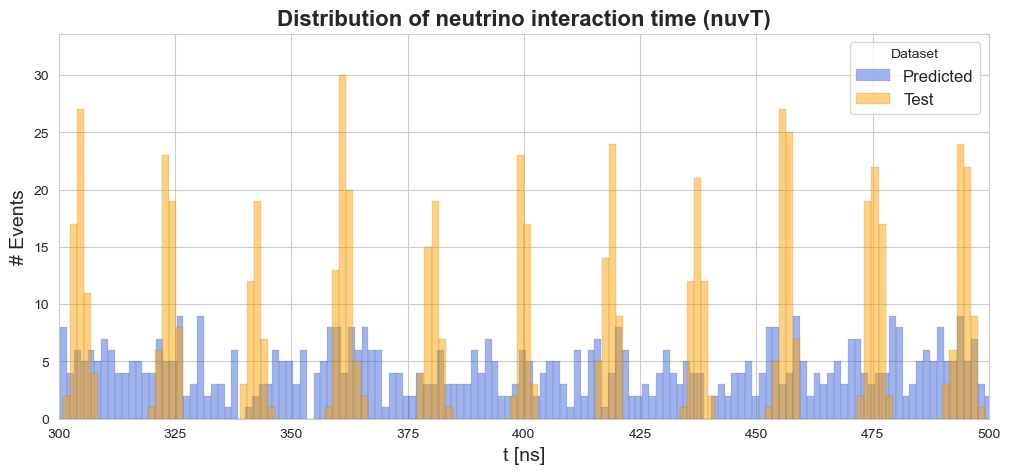

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Establecer un estilo atractivo
sns.set_style("whitegrid")

# Crear la figura y los ejes
plt.figure(figsize=(12, 5))

# Histograma con bordes definidos y transparencia
sns.histplot(y_pred_inverse[:, 0], bins=1000, color='royalblue', edgecolor='black', alpha=0.5, label='Predicted')
sns.histplot(y_test_inverse[:, 0], bins=1000, color='orange', edgecolor='black', alpha=0.5, label='Test')

# Etiquetas y título con fuente más grande
plt.xlabel('t [ns]', fontsize=14)
plt.ylabel('# Events', fontsize=14)
plt.title('Distribution of neutrino interaction time (nuvT)', fontsize=16, fontweight='bold')

# Ajustar el rango del eje X
plt.xlim(300, 500)

# Agregar una leyenda
plt.legend(title='Dataset', fontsize=12)

# Mostrar la gráfica
plt.show()


**quizá haya que quitarle nuvT al predicted**

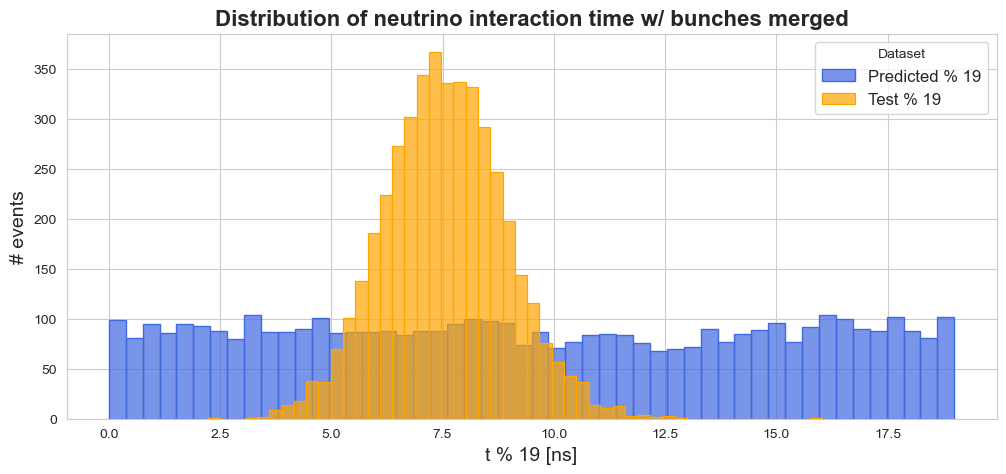

In [58]:
# Aplicar módulo 19
y_pred_mod_19 = y_pred_inverse[:, 0] % 19
y_test_mod_19 = (y_test_inverse[:, 0] + 7) % 19

# Establecer un estilo atractivo
sns.set_style("whitegrid")

# Crear la figura y los ejes
plt.figure(figsize=(12, 5))

# Histograma con bordes definidos y transparencia
sns.histplot(y_pred_mod_19, bins=50, color='royalblue', edgecolor='royalblue', alpha=0.7, label='Predicted % 19')
sns.histplot(y_test_mod_19, bins=50, color='orange', edgecolor='orange', alpha=0.7, label='Test % 19')

# Etiquetas y título con fuente más grande
plt.xlabel('t % 19 [ns]', fontsize=14)
plt.ylabel('# events', fontsize=14)
plt.title('Distribution of neutrino interaction time w/ bunches merged', fontsize=16, fontweight='bold')

# Agregar una leyenda
plt.legend(title='Dataset', fontsize=12)

# Mostrar la gráfica
plt.show()


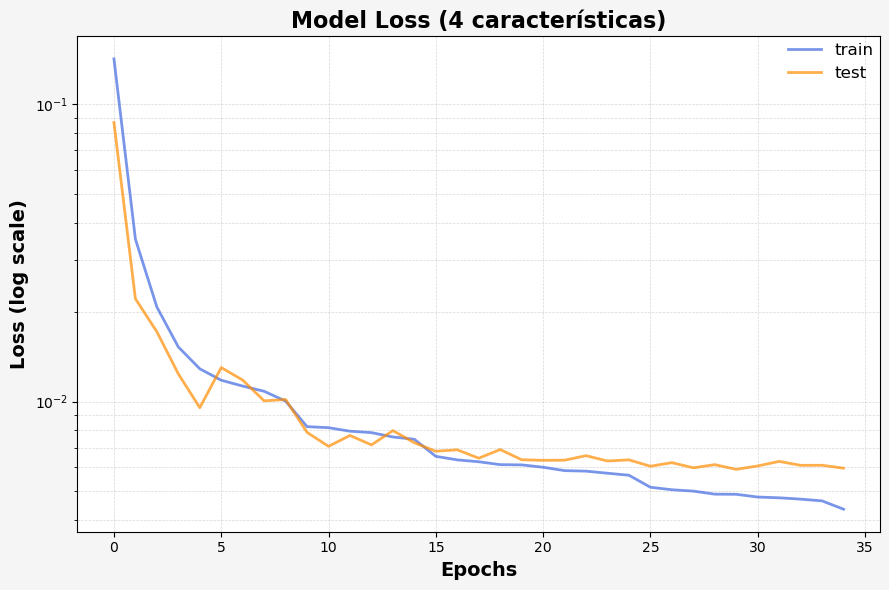

In [32]:
import matplotlib.pyplot as plt

# Access each model's history
model_history = history.history


# Plotting the validation loss for all models
plt.figure(figsize=(9, 6))

# Plot each model's validation loss with smoother lines, subtle markers, and clearer styling
# Training curves (using shades of blue and green)
plt.plot(model_history['loss'], label='train', color='royalblue', linestyle='-', markersize=6, alpha=0.7, linewidth=2)


# Testing curves (using shades of orange and red)
plt.plot(model_history['val_loss'], label='test', color='darkorange', linestyle='-', markersize=6, alpha=0.7, linewidth=2)


# Enhance plot appearance
plt.yscale('log')  # Use logarithmic scale on y-axis
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Loss (log scale)', fontsize=14, fontweight='bold')
plt.title('Model Loss (4 características)', fontsize=16, fontweight='bold')

# Refined grid with lighter lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)

# Add legend with better positioning and larger font
plt.legend(fontsize=12, loc='upper right', bbox_to_anchor=(1, 1), borderaxespad=0., frameon=False)

# Add background color for plot to make it stand out
plt.gcf().set_facecolor('whitesmoke')

# Show plot with a tight layout to avoid clipping
plt.tight_layout()
plt.show()


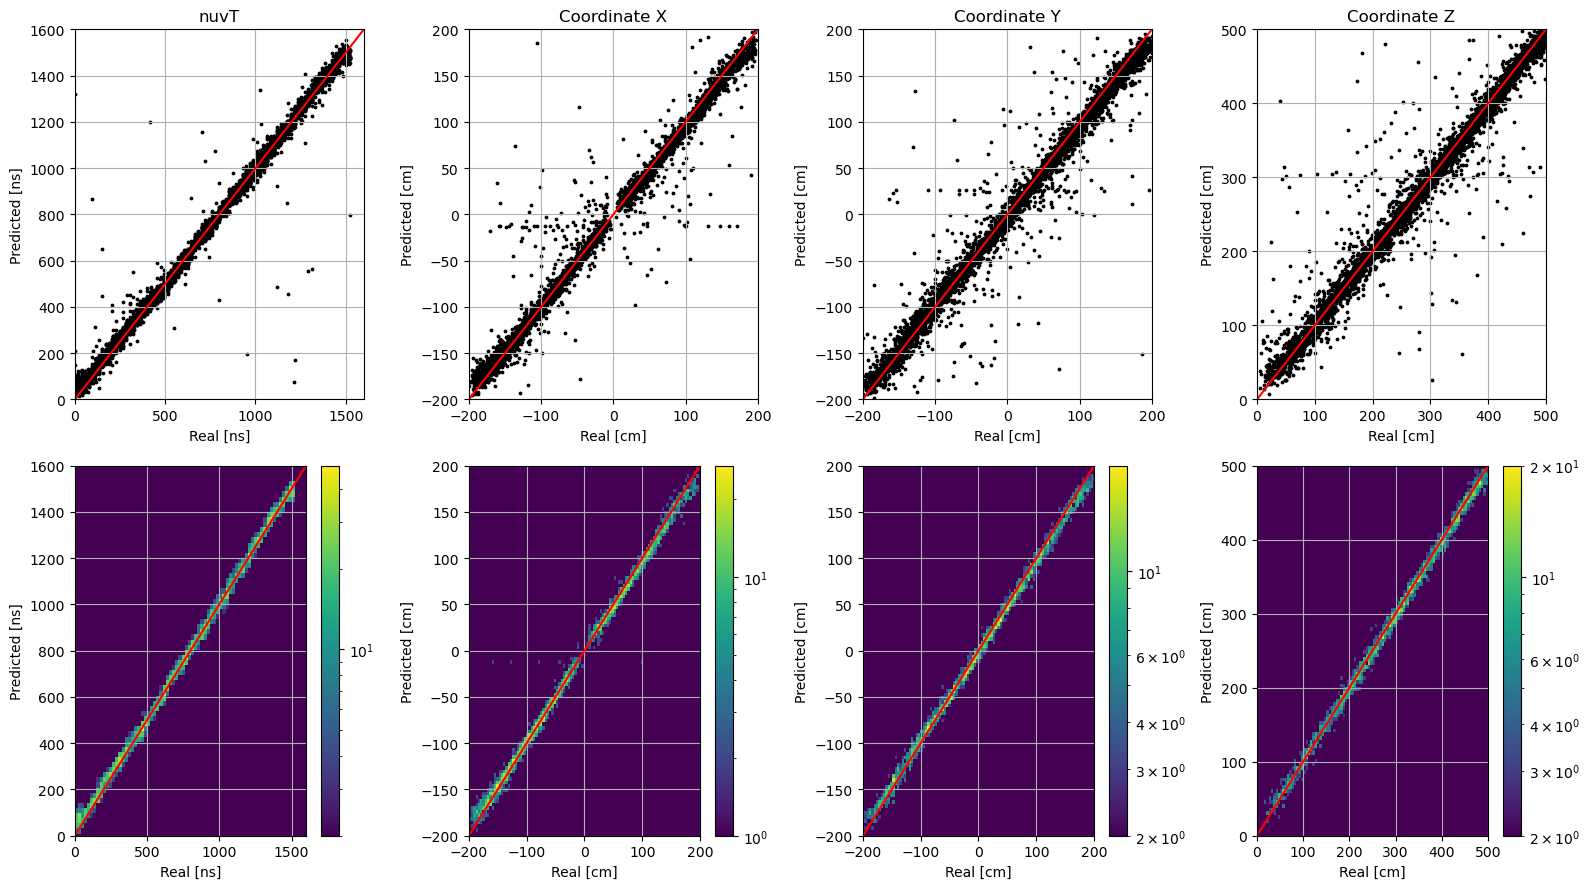

In [33]:
import matplotlib.colors as mcolors
fig, axs = plt.subplots(2,4,figsize=(16,9))

axs[0,0].scatter(y_test_inverse[:,0], y_pred_inverse[:,0], color="black",s=3)
axs[0,0].grid()

axs[0,0].plot([0,1600],[0,1600],color="r")
axs[0,0].title.set_text('nuvT')
axs[0,0].set_xlim([0,1600])
axs[0,0].set_ylim([0,1600])
axs[0,0].set_ylabel('Predicted [ns]')
axs[0,0].set_xlabel('Real [ns]')

im0 = axs[1,0].hist2d(y_test_inverse[:,0], y_pred_inverse[:,0].flatten(), bins=(70, 70), cmap='viridis', cmin=2, norm=mcolors.LogNorm())
fig.colorbar(im0[3], ax=axs[1,0])
axs[1,0].grid()

axs[1,0].plot([0,1600],[0,1600],'r')
axs[1,0].set_xlim([0,1600])
axs[1,0].set_ylim([0,1600])
axs[1,0].set_ylabel('Predicted [ns]')
axs[1,0].set_xlabel('Real [ns]')
axs[1,0].set_facecolor('#440154')


axs[0,1].scatter(y_test_inverse[:,1], y_pred_inverse[:,1], color="black",s=3)
axs[0,1].grid()

axs[0,1].plot([-200,200],[-200,200],color="r")
axs[0,1].title.set_text('Coordinate X')
axs[0,1].set_xlim([-200,200])
axs[0,1].set_ylim([-200,200])
axs[0,1].set_ylabel('Predicted [cm]')
axs[0,1].set_xlabel('Real [cm]')


im1 = axs[1,1].hist2d(y_test_inverse[:,1], y_pred_inverse[:,1].flatten(), bins=(100, 100), cmap='viridis', cmin=0,cmax=30, norm=mcolors.LogNorm())
fig.colorbar(im1[3], ax=axs[1,1])
axs[1,1].grid()

axs[1,1].plot([-200,200],[-200,200],'r')
axs[1,1].set_xlim([-200,200])
axs[1,1].set_ylim([-200,200])
axs[1,1].set_ylabel('Predicted [cm]')
axs[1,1].set_xlabel('Real [cm]')
axs[1,1].set_facecolor('#440154')


axs[0,2].scatter(y_test_inverse[:,2], y_pred_inverse[:,2], color="black",s=3)
axs[0,2].grid()

axs[0,2].plot([-200,200],[-200,200],color="r")
axs[0,2].title.set_text('Coordinate Y')
axs[0,2].set_xlim([-200,200])
axs[0,2].set_ylim([-200,200])
axs[0,2].set_ylabel('Predicted [cm]')
axs[0,2].set_xlabel('Real [cm]')


im2 = axs[1,2].hist2d(y_test_inverse[:,2], y_pred_inverse[:,2].flatten(), bins=(100, 100), cmap='viridis',cmin=2, cmax=30, norm=mcolors.LogNorm())
fig.colorbar(im2[3], ax=axs[1,2])
axs[1,2].grid()

axs[1,2].plot([-200,200],[-200,200],'r')
axs[1,2].set_xlim([-200,200])
axs[1,2].set_ylim([-200,200])
axs[1,2].set_ylabel('Predicted [cm]')
axs[1,2].set_xlabel('Real [cm]')
axs[1,2].set_facecolor('#440154')


axs[0,3].scatter(y_test_inverse[:,3], y_pred_inverse[:,3], color="black",s=3)
axs[0,3].grid()

axs[0,3].plot([0,500],[0,500],color="r")
axs[0,3].title.set_text('Coordinate Z')
axs[0,3].set_xlim([0,500])
axs[0,3].set_ylim([0,500])
axs[0,3].set_ylabel('Predicted [cm]')
axs[0,3].set_xlabel('Real [cm]')


im3 = axs[1,3].hist2d(y_test_inverse[:,3], y_pred_inverse[:,3].flatten(), bins=(100, 100), cmap='viridis',cmin=2, cmax=30, norm=mcolors.LogNorm())
fig.colorbar(im3[3], ax=axs[1,3])
axs[1,3].grid()

axs[1,3].set_xlim([0,500])
axs[1,3].set_ylim([0,500])
axs[1,3].plot([0,500],[0,500], 'r')
axs[1,3].set_ylabel('Predicted [cm]')
axs[1,3].set_xlabel('Real [cm]')
axs[1,3].set_facecolor('#440154')

fig.tight_layout()

plt.show()
#plt.savefig('/tmp/...', dpi=300)

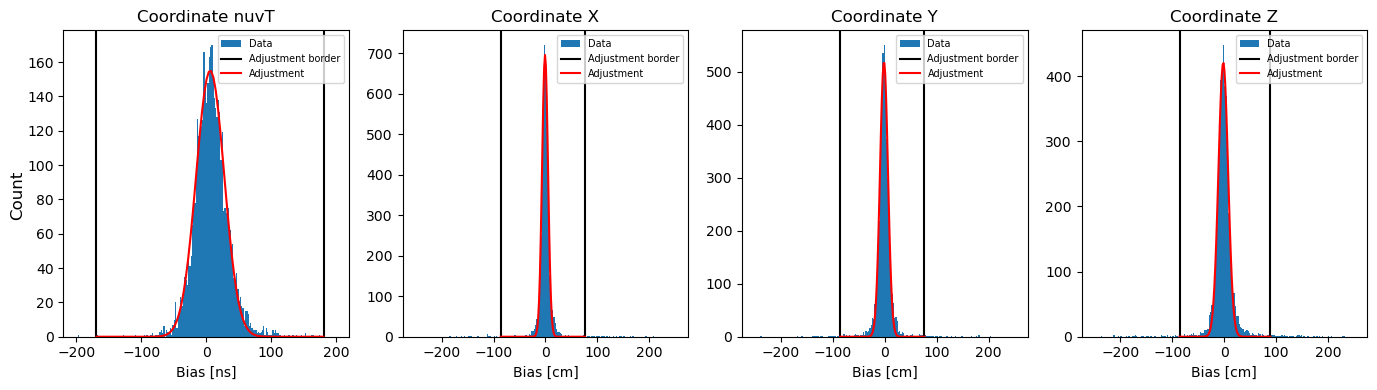

Bias Adjustment variables
------------------
Mean nuvT = 6.34
Sigma nuvT = 21.65
------------------
Mean X = -0.82
Sigma X = 5.69
------------------
Mean Y = -1.70
Sigma Y = 7.63
------------------
Mean Z = -1.92
Sigma Z = 9.32
------------------


In [35]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Define the Gaussian function
def func(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Calculating the differences between the prediction and the real value
diffnuvT = y_pred_inverse[:, 0].flatten() - y_test_inverse[:, 0]
diffX = y_pred_inverse[:, 1].flatten() - y_test_inverse[:, 1]
diffY = y_pred_inverse[:, 2].flatten() - y_test_inverse[:, 2]
diffZ = y_pred_inverse[:, 3].flatten() - y_test_inverse[:, 3]

# Create subplots for each coordinate
fig, axs = plt.subplots(1, 4, figsize=(14, 4))

# Updated fit_and_plot_hist for nuvT with range [-400, 400]
def fit_and_plot_hist(diff, axs, index, coord_name, ini, fin, hist_range):
    counts, bins, patches = axs[index].hist(diff, 200, range=hist_range, label='Data')
    step = (bins[1] - bins[0]) / 2
    bin_centers = bins[:-1] + step

    # Ensure the fit range is within the histogram bounds
    ini = max(0, min(ini, len(bin_centers) - 1))
    fin = max(ini + 1, min(fin, len(bin_centers) - 1))

    axs[index].axvline(x=bin_centers[ini], color='k', label='Adjustment border')
    axs[index].axvline(x=bin_centers[fin], color='k')

    # Gaussian Fit for the data
    p0 = [np.max(counts), 0, 50]  # Amplitude, mean, sigma (adjust based on your data)
    popt, _ = curve_fit(func, bin_centers[ini:fin+1], counts[ini:fin+1], p0=p0, bounds=([0, -np.inf, 0], [np.inf, np.inf, np.inf]))
    ym = func(np.linspace(bin_centers[ini], bin_centers[fin], 100), *popt)
    axs[index].plot(np.linspace(bin_centers[ini], bin_centers[fin], 100), ym, c='r', label='Adjustment')

    axs[index].set_xlabel('Bias [cm]' if coord_name != 'nuvT' else 'Bias [ns]')  # Set different xlabel for nuvT
    axs[index].set_title(f'Coordinate {coord_name}')
    axs[index].legend(prop={"size": 7})

    return popt

# Call the function with updated range for nuvT
popt_nuvT = fit_and_plot_hist(diffnuvT, axs, 0, 'nuvT', 15, 190, hist_range=[-200, 200])
popt_X = fit_and_plot_hist(diffX, axs, 1, 'X', 65, 130, hist_range=[-250, 250])
popt_Y = fit_and_plot_hist(diffY, axs, 2, 'Y', 65, 130, hist_range=[-250, 250])
popt_Z = fit_and_plot_hist(diffZ, axs, 3, 'Z', 65, 135, hist_range=[-250, 250])


# Adjust layout
fig.supylabel('Count')
fig.tight_layout()

# Show the plot
plt.show()

# Print adjustment variables
print('Bias Adjustment variables')
print('------------------')
print(f'Mean nuvT = {popt_nuvT[1]:.2f}')
print(f'Sigma nuvT = {popt_nuvT[2]:.2f}')
print('------------------')
print(f'Mean X = {popt_X[1]:.2f}')
print(f'Sigma X = {popt_X[2]:.2f}')
print('------------------')
print(f'Mean Y = {popt_Y[1]:.2f}')
print(f'Sigma Y = {popt_Y[2]:.2f}')
print('------------------')
print(f'Mean Z = {popt_Z[1]:.2f}')
print(f'Sigma Z = {popt_Z[2]:.2f}')
print('------------------')


In [44]:
# Print adjustment variables
print('Precision Adjustment variables')
print('------------------')
print(f'Sigma nuvT = {(1 - popt_nuvT[2] / (np.max(y_test_inverse[:, 0]) - np.min(y_test_inverse[:, 0]))) * 100:.2f}%')
print('------------------')
print(f'Sigma X = {(1 - popt_X[2] / (np.max(y_test_inverse[:, 1]) - np.min(y_test_inverse[:, 1]))) * 100:.2f}%')
print('------------------')
print(f'Sigma Y = {(1 - popt_Y[2] / (np.max(y_test_inverse[:, 2]) - np.min(y_test_inverse[:, 2]))) * 100:.2f}%')
print('------------------')
print(f'Sigma Z = {(1 - popt_Z[2] / (np.max(y_test_inverse[:, 1]) - np.min(y_test_inverse[:, 1]))) * 100:.2f}%')
print('------------------')

Precision Adjustment variables
------------------
Sigma nuvT = 96.64%
------------------
Sigma X = 96.13%
------------------
Sigma Y = 96.51%
------------------
Sigma Z = 92.96%
------------------
